### 6 November 2019

# Extend RefSeq regions and assess % recovery of ClinVar variants by extension length with bedtools slop
### Pavlos Bousounis
***Last update 2019-11-12***

In [47]:
# import required modules
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pathlib
import pybedtools
from pybedtools import BedTool
import re
import seaborn as sns

In [48]:
# set base directory
basedir = '/Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data'

In [49]:
# get today's date as YYYY-MM-DD
today = datetime.today().strftime('%Y-%m-%d')
print('Today is ' + today)

Today is 2019-11-13


## Define the bed_not function

In [50]:
# define the not-element-of function to get regions unique to the test_bed file
def bed_not(bed_a_file, bed_b_file):
    
    """ Given two bed files, ref_bed and test_bed, perform bedtools intersect -v to return only
    regions in the ref_bed file that do NOT overlap any regions in the test_bed file. """
    
    # specify the reference bed file
    a_bedtool = BedTool(bed_a_file)
    prfx_a = bed_a_file.split('/')[-1]
    prfx_a = prfx_a.split('.')[0]
    
    # specify the new ClinVar bed file
    b_bedtool = BedTool(bed_b_file)
    prfx_b = bed_b_file.split('/')[-1]
    prfx_b = prfx_b.split('.')[0]

    # specify name/path of output bed file
    out_bed_filepath = '{}/{}_NotIn_{}.bed'.format(os.getcwd(), prfx_a, prfx_b)
    
    # run bedtools intersect to get all test_bed regions NOT found in ref_bed (-v option)
    a_NotIn_b = a_bedtool.intersect(b=b_bedtool, v=True)
    a_NotIn_b.head()
    
    # save 
    a_NotIn_b.saveas(out_bed_filepath)
    feat_count = a_NotIn_b.count()
    
    # confirm file saved
    print('\nNumber of {} features NOT IN {} = {}'.format(prfx_a, prfx_b, feat_count))
    
    if os.path.exists(out_bed_filepath):
        print('Success! File saved to {}.'.format(os.path.join(os.getcwd(), out_bed_filepath)))

    return(feat_count)

In [51]:
# create slop file output directory
slop_dir_out = os.path.join(basedir, (today + "_RefSeqGRCh37_exon_slop_bed"))
pathlib.Path(slop_dir_out).mkdir(exist_ok=True)

In [52]:
# create the ClinVar bedtool
clinvar_bed_filepath = os.path.join(basedir, '2019-11-07_ClinVar-GRCh37_path-likely_path.bed')
clinvar_bed = pd.read_csv(clinvar_bed_filepath, sep='\t', header=None, low_memory=False).drop([0, 0])
clinvar_bed[0] = 'chr' + clinvar_bed.loc[:, 0]            
  
clinvar_bedtool = BedTool.from_dataframe(clinvar_bed)       

# save headless clinvar bed
clinvar_bed_out = os.path.join(basedir, '2019-11-07-GRCh37_path-likely_path_headless.bed')
clinvar_bed.to_csv(clinvar_bed_out, sep='\t', header=None, index=False)

In [53]:
# create the RefSeq bedtool
refseq_bed_filepath = os.path.join(basedir, '2019-11-08_RefSeq-GRCh37_latest_genomicGFF3.bed')
refseq_bed = pd.read_csv(refseq_bed_filepath, sep='\t', header=None, low_memory=False)
refseq_bed[0] = 'chr' + refseq_bed.loc[:, 0]    
          
refseq_bedtool = BedTool.from_dataframe(refseq_bed)

# save headless refseq bed
refseq_bed_out = os.path.join(basedir, '2019-11-08_RefSeq-GRCh37_latest_genomicGFF3_headless.bed')
refseq_bed.to_csv(refseq_bed_out, sep='\t', header=None, index=False)


In [54]:
# retrieve hg19 chromosome sizes for pybedtools slop
hg19_genome = pybedtools.helpers.get_chromsizes_from_ucsc(genome='hg19', saveas='data/hg19.genome')

In [55]:
# for each N in the interval 0, 5, 10, .., 155 (non-inclusive) run bedtools slop adding N bases to each end of each region
for i in list(range(5, 20, 5)):
    
    # create the output filename
    file_out = os.path.join(os.getcwd(), slop_dir_out, '{}_RefSeqGRCh37_slop{}.bed'.format(today, i))
    
    # perform slop: add 'i' bases to each end of each region
    refseq_bedtool.slop(g=hg19_genome, b=i).saveas(file_out)
    
    # check file save
    if os.path.isfile(os.path.join(os.getcwd(), file_out)):
        print('\nSuccess! File saved:\n{}\n'.format(file_out))


Success! File saved:
/Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data/2019-11-13_RefSeqGRCh37_exon_slop_bed/2019-11-13_RefSeqGRCh37_slop5.bed


Success! File saved:
/Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data/2019-11-13_RefSeqGRCh37_exon_slop_bed/2019-11-13_RefSeqGRCh37_slop10.bed


Success! File saved:
/Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data/2019-11-13_RefSeqGRCh37_exon_slop_bed/2019-11-13_RefSeqGRCh37_slop15.bed



In [36]:
bed_a_file = '2019-11-07-GRCh37_path-likely_path_headless.bed'

slop_files = glob.glob('2019-11-12_RefSeqGRCh37_exon_slop_bed/*RefSeqGRCh37_slop*.bed')

mydict = {}
for i in slop_files:
    slop_num = re.findall(r'\d+', i)[-1]
    fname = '{}_RefSeqGRCh37_ClinVar_recovery_{}.bed'.format(today, slop_num)
    mydict[slop_num]= bed_not(bed_a_file, i)

chr1	7681999	7682000	599309_CAMTA1
 chr1	11850972	11850973	187901_MTHFR
 chr1	11863211	11863212	187865_MTHFR
 chr1	26126648	26126649	665196_SELENON
 chr1	26126664	26126665	659413_SELENON
 chr1	26774025	26774026	488195_DHDDS
 chr1	46658169	46658170	370335_TSPAN1
 chr1	94484000	94484001	438100_ABCA4
 chr1	94492999	94493000	560421_ABCA4
 chr1	94509046	94509047	417986_ABCA4
 
Number of 2019-11-07-GRCh37_path-likely_path_headless features NOT IN 2019-11-12_RefSeqGRCh37_slop15 = 913
Success! File saved to /Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data/2019-11-07-GRCh37_path-likely_path_headless_NotIn_2019-11-12_RefSeqGRCh37_slop15.bed.
chr1	7681999	7682000	599309_CAMTA1
 chr1	11850972	11850973	187901_MTHFR
 chr1	11863211	11863212	187865_MTHFR
 chr1	15772079	15772080	439575_CTRC
 chr1	17354229	17354230	468236_SDHB
 chr1	26126648	26126649	665196_SELENON
 chr1	26126664	26126665	659413_SELENON
 chr1	26774025	26774026	488195_DHDDS
 chr1	40558193	4

In [30]:
slop_files
#os.chdir('/Users/pbousounis/Experiments/2019-10-29_hg19mod/RefSeq-ClinVar_GRCh37_slop_region_recovery/data')

['./2019-11-12_RefSeqGRCh37_exon_slop_bed/2019-11-12_RefSeqGRCh37_slop15.bed',
 './2019-11-12_RefSeqGRCh37_exon_slop_bed/2019-11-12_RefSeqGRCh37_slop10.bed',
 './2019-11-12_RefSeqGRCh37_exon_slop_bed/2019-11-12_RefSeqGRCh37_slop5.bed']

In [37]:
mydict

{'15': 913, '10': 1101, '5': 1737}

In [39]:
# reformat dictionary and convert to dataframe
slop_num = []
cv_not_rs = []
for x in mydict:
    slop_num.append(x)
    cv_not_rs.append(mydict[x])

newdict = {
    'region_slop':slop_num, 'clinvar_NOT_recovered':cv_not_rs
}

slop_df = pd.DataFrame.from_dict(newdict)
slop_df.region_slop = pd.to_numeric(slop_df.region_slop, errors='coerce')
df = slop_df.sort_values(by = ['region_slop']).reset_index()
del df['index']

df_fileout = today + '_RefSeq-GRCh37_vs_ClinVar-path-l-SLOPS.tsv'
df.to_csv(df_fileout, sep = '\t', index=False)
if os.path.isfile(df_fileout):
    print('Success! {} saved.'.format(df_fileout))

Success! 2019-11-12_RefSeq-GRCh37_vs_ClinVar-path-l-SLOPS.tsv saved.


In [40]:
df

,region_slop,clinvar_NOT_recovered
0,5,1737
1,10,1101
2,15,913


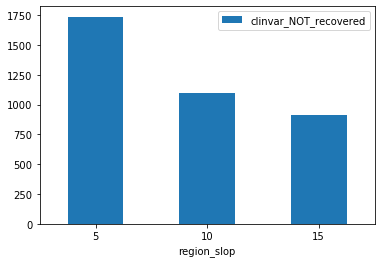

In [46]:
# Plot the data
df.plot.bar(x='region_slop', y='clinvar_NOT_recovered', rot = 0) 